<a href="https://colab.research.google.com/github/aisha-partha/AIMLOps-MiniProjects/blob/mp_4/M2_NB_MiniProject_2_DeepLabV3%2B_Lungs_Segmentation_ver_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project: Lung Segmentation of Chest X-Ray dataset using DeepLabV3+

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture
- create a masked image (prediction)

## Introduction

Semantic segmentation is a computer vision task that involves dividing an image into different regions, each of which is labeled with a semantic category. The goal of semantic segmentation is to enable machines to understand the content of an image at a pixel level, by assigning a label to each individual pixel based on the object or region it belongs to.

This technique is widely used in many applications such as self-driving cars, medical image analysis, and object recognition in robotics. It helps to extract meaningful information from images and to understand the relationships between objects and their environment.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://cdn.iisc.talentsprint.com/AIandMLOps/Images/segmentation_vs_other_algos.jpeg' width=700px>
<br><br>

Moreover, in contrast to object detection, which detects and localizes objects within an image, semantic segmentation is more precise and detailed. It provides a much more granular understanding of the content of an image, allowing for more advanced and accurate applications.

## Dataset

*  The Chest X-Ray dataset is made up of images and segmentated mask from two diffrent sources - Shenzhen and Montgomery dataset
*  The CXR_png folder consists of Chest X-Rays and the masks folder has the segmented mask
*  There are 704 images with their masks mapped with each other  

<br>
$\quad$<img src='https://cdn.extras.talentsprint.com/AIandMLOps/Images/semantic_segmentation.png' width=700px>
<br><br>


## Problem Statement

Perfrom the lungs segmentation on Chest X-Ray dataset using DeepLabV3+ model.

## Grading = 10 Points

In [4]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
!unzip -qq LungSegmentation.zip
print("Data Downloaded Successfuly!!")

--2024-06-07 04:08:42--  https://cdn.iisc.talentsprint.com/AIandMLOps/MiniProjects/Datasets/LungSegmentation.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139904834 (133M) [application/zip]
Saving to: ‘LungSegmentation.zip’

LungSegmentation.zi 100%[===================>] 133.42M   302KB/s    in 3m 11s  

2024-06-07 04:11:53 (716 KB/s) - ‘LungSegmentation.zip’ saved [139904834/139904834]

Data Downloaded Successfuly!!


### Import required packages

In [6]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **PART-A**

### Data Visualization (1 point)

#### Image Visualization
Visualize one of the Chest X-Ray image and its segmented label image.

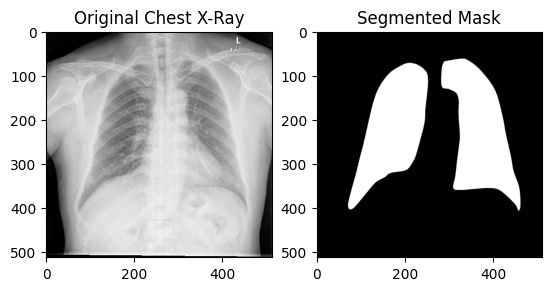

In [7]:
# Visualize an image
# Visualize a semantic part segmentation label image
# YOUR CODE HERE
# Load an example image and mask
image_path = '/content/LungSegmentation/CXR_png/CHNCXR_0001_0.png'
mask_path = '/content/LungSegmentation/masks/CHNCXR_0001_0.png'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Chest X-Ray')

# Plot the segmented mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmented Mask')

plt.show()

### Create a TensorFlow Dataset (1 points)
Use the image size, batch size, number of classes, and data directory as given in the below code cell.

Hint:
1. Find all the image files in the CXR_png and masks subdirectory separately. The resulting list should be sorted in ascending order.
2. Create a list of validation image, validation masks, test image, test masks, etc.
3. Create a function that reads an image file and returns a preprocessed image tensor.  

In [8]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 2
# Set your data directory
DATA_DIR = "./LungSegmentation"

# Find paths for all the image files in the 'CXR_png' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_images = [os.path.join(DATA_DIR, "CXR_png", filename) for filename in os.listdir(os.path.join(DATA_DIR, "CXR_png"))]

# Find paths for all the mask files in the 'masks' subdirectory of the DATA_DIR directory.
# Sort the list of file paths in ascending order
all_masks = [os.path.join(DATA_DIR, "masks", filename) for filename in os.listdir(os.path.join(DATA_DIR, "masks"))]

In [9]:
import random
#Cateogorizing images in 4 samples
images_sample1 = []
images_sample2 = []
images_sample3 = []
images_sample4 = []
for i in range(len(all_images)):
    if all_images[i].split('/')[-1].split('.')[0][0] == "C" and all_images[i].split('/')[-1].split('.')[0][-1] == "0":
        images_sample1.append(all_images[i])
    elif all_images[i].split('/')[-1].split('.')[0][0] == "C" and all_images[i].split('/')[-1].split('.')[0][-1] == "1":
        images_sample2.append(all_images[i])
    elif all_images[i].split('/')[-1].split('.')[0][0] == "M" and all_images[i].split('/')[-1].split('.')[0][-1] == "0":
        images_sample3.append(all_images[i])
    else:
        images_sample4.append(all_images[i])


# Randomly sample from each category of image
sampled_train_images = []
for images in [images_sample1, images_sample2, images_sample3, images_sample4]:
    sampled_train_images.extend(random.sample(images, int(0.7*len(images))))

sampled_val_test_images = []
sampled_val_images =[]
for images in [images_sample1, images_sample2, images_sample3, images_sample4]:
    for image in images:
        if image not in sampled_train_images:
            sampled_val_test_images.append(image)

sampled_val_images.extend(random.sample(sampled_val_test_images, int(0.5*len((sampled_val_test_images)))))

sampled_test_images =[]
for image in sampled_val_test_images:
    if image not in sampled_val_images:
        sampled_test_images.append(image)


print('all images :',len(all_images))
print ('Sample 1 : ', len(images_sample1))
print ('Sample 2 : ', len(images_sample2))
print ('Sample 3 : ', len(images_sample3))
print ('Sample 4 : ', len(images_sample4))
print ('Sampled Trained Images : ', len(sampled_train_images))
print ('Sampled Val Images : ', len(sampled_val_images))
print ('Sampled Test Images : ', len(sampled_test_images))




all images : 704
Sample 1 :  279
Sample 2 :  287
Sample 3 :  80
Sample 4 :  58
Sampled Trained Images :  491
Sampled Val Images :  106
Sampled Test Images :  107


In [10]:
#indexing the masks set to images
sampled_train_masks = []
sampled_val_masks= []
sampled_test_masks= []
for i in range(len(all_masks)):
    flag = 0
    for j in range(len(sampled_train_images)):
        if all_masks[i].split('/')[-1].split('.')[0] == sampled_train_images[j].split('/')[-1].split('.')[0]:
            sampled_train_masks.append(all_masks[i])
            flag = 1
            break
    if (flag == 0):
        for x in range(len(sampled_val_images)):
            if all_masks[i].split('/')[-1].split('.')[0] == sampled_val_images[x].split('/')[-1].split('.')[0]:
                sampled_val_masks.append(all_masks[i])
                flag = 1
                break
    if (flag == 0):
        sampled_test_masks.append(all_masks[i])


sampled_train_images = sorted(sampled_train_images)
sampled_val_images = sorted(sampled_val_images)
sampled_test_images = sorted(sampled_test_images)
sampled_train_masks = sorted(sampled_train_masks)
sampled_val_masks = sorted(sampled_val_masks)
sampled_test_masks = sorted(sampled_test_masks)

print(sampled_train_images[:5])
print(sampled_train_masks[:5])
print(sampled_val_images[:5])
print(sampled_val_masks[:5])
print(sampled_test_images[:5])
print(sampled_test_masks[:5])

['./LungSegmentation/CXR_png/CHNCXR_0001_0.png', './LungSegmentation/CXR_png/CHNCXR_0002_0.png', './LungSegmentation/CXR_png/CHNCXR_0005_0.png', './LungSegmentation/CXR_png/CHNCXR_0006_0.png', './LungSegmentation/CXR_png/CHNCXR_0007_0.png']
['./LungSegmentation/masks/CHNCXR_0001_0.png', './LungSegmentation/masks/CHNCXR_0002_0.png', './LungSegmentation/masks/CHNCXR_0005_0.png', './LungSegmentation/masks/CHNCXR_0006_0.png', './LungSegmentation/masks/CHNCXR_0007_0.png']
['./LungSegmentation/CXR_png/CHNCXR_0004_0.png', './LungSegmentation/CXR_png/CHNCXR_0009_0.png', './LungSegmentation/CXR_png/CHNCXR_0024_0.png', './LungSegmentation/CXR_png/CHNCXR_0031_0.png', './LungSegmentation/CXR_png/CHNCXR_0033_0.png']
['./LungSegmentation/masks/CHNCXR_0004_0.png', './LungSegmentation/masks/CHNCXR_0009_0.png', './LungSegmentation/masks/CHNCXR_0024_0.png', './LungSegmentation/masks/CHNCXR_0031_0.png', './LungSegmentation/masks/CHNCXR_0033_0.png']
['./LungSegmentation/CXR_png/CHNCXR_0003_0.png', './Lung

In [11]:

# Function to read an image file and returns a preprocessed image tensor.
# The mask argument is set to False by default, indicating that it is an image file, not a mask file.
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def read_image(image_path, mask = False):  #Pre-processing Images

    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image

Create a **load_data** function that takes in two arguments, **image_list** and **mask_list**, which are lists of file paths to the images and corresponding masks, respectively. It then reads in the image and mask using the **read_image** function defined earlier. The function returns a tuple of **image** and **mask**.

In [12]:
def load_data(image_path, mask_path):
    image = read_image(image_path)
    mask = read_image(mask_path, mask=True)
    return image, mask

#val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
#val_dataset = val_dataset.map(lambda x, y: (read_image(x), read_image(y, mask = True)))
#test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
#test_dataset = test_dataset.map(lambda x, y: (read_image(x), read_mask(y, mask = True)))

Create a **data_generator** function that takes in **image_list** and **mask_list** as arguments.

The function should:
- create a **tf.data.Dataset** object from the input data
- map the **load_data** function to each element in the dataset
- convert the dataset into batches of size **BATCH_SIZE**, drop any incomplete batch at the end of the dataset
- return the resulting dataset

In [13]:
# Generate train and validation set

def data_generator(image_list, mask_list):
    # Create a dataset from image and mask lists
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data)
    #Batch the dataset and drop any incomplete batch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

    return dataset

train_dataset = data_generator(sampled_train_images, sampled_train_masks)
train_dataset = train_dataset.shuffle(buffer_size=len(sampled_train_images))
val_dataset = data_generator(sampled_val_images, sampled_val_masks)
test_dataset = data_generator(sampled_test_images, sampled_test_masks)

print('Train  Dataset: ', train_dataset)
print('Val  Dataset: ',  val_dataset)

# Example usage:
for batch in train_dataset.take(2):
    images_batch, masks_batch = batch
    print(images_batch.shape)  # Shape should be (batch_size, IMAGE_SIZE, IMAGE_SIZE, 3)
    print(masks_batch.shape)


Train  Dataset:  <_ShuffleDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val  Dataset:  <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
(4, 512, 512, 3)
(4, 512, 512, 1)
(4, 512, 512, 3)
(4, 512, 512, 1)


Check the total images for train and validation.

In [14]:
# YOUR CODE HERE
print('Total no images in Train set: ',len(train_dataset)*BATCH_SIZE)
print('Total no images in Val set: ',len(val_dataset)*BATCH_SIZE)

Total no images in Train set:  488
Total no images in Val set:  104


Check the number of batches formed in train and validation set.


In [15]:
# YOUR CODE HERE
print('Total no images in Train batches: ',int(len(train_dataset)))
print('Total no images in Val Batches: ',int(len(val_dataset)))


Total no images in Train batches:  122
Total no images in Val Batches:  26


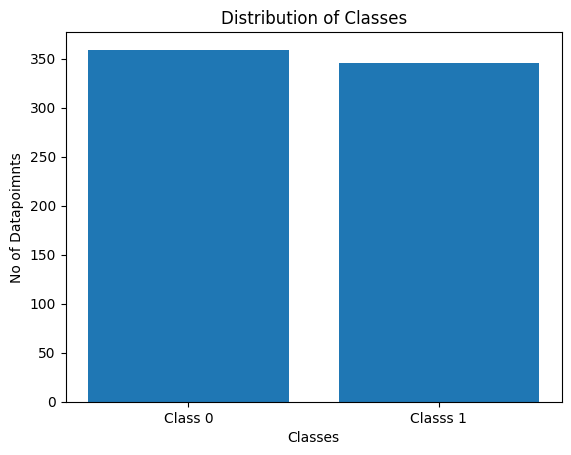

In [16]:
sample_Class_0 = images_sample1 + images_sample3
sample_Class_1 = images_sample2 + images_sample4

# Calculate lengths
length1 = len(sample_Class_0)
length2 = len(sample_Class_1)

# Create a bar plot
plt.bar(['Class 0', 'Classs 1'], [length1, length2])
plt.xlabel('Classes')
plt.ylabel('No of Datapoimnts')
plt.title('Distribution of Classes')
plt.show()

Now, we have created our TensorFlow Dataset. Further, let us try to understand the DeepLabV3+ model.

### **PART-B**

### Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregate context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/Dilated_Conv.jpg" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_model.png" width=1000px>
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EfficientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


### Create the model (5 points)
First, create different functions  to implement DeepLabV3+ architecture.



Create a function, **convolution_block()**, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [17]:
# YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def convolution_block(input_block, filters=256, kernel_size = (1,1),dilation_rate = 1, padding='same', activation='relu', use_bias=False):
    x = layers.Conv2D(filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                        padding="same", use_bias=use_bias,
                        kernel_initializer=keras.initializers.HeNormal())(input_block)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x
# Example usage:
#conv_block = convolution_block(filters=64, kernel_size=(3, 3))


Create another function to perform **Dilated Spatial Pyramid Pooling**. Use above function to add different convolution blocks.

In [18]:
# YOUR CODE HERE

def DilatedSpatialPyramidPooling(input_tensor, dilation_rates = (1,6,12,18)):
    dims = input_tensor.shape
    print('Input tensor in DSPP :- ', input_tensor.shape)

    processed_features = []
    for rate in dilation_rates:
        if (rate==1):
            dilated_conv = convolution_block(input_tensor)
        else:
            dilated_conv = convolution_block(input_tensor, kernel_size=(3, 3), dilation_rate=rate)

        processed_features.append(dilated_conv)

    # Image pooling
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(input_tensor)
    x = convolution_block(x)
    print('Shape of average pooling in DSPP', x.shape)
    out_pool = layers.UpSampling2D(size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation = "bilinear")(x)
    print('Shape of outpool in encoder becfore concatanation : ', out_pool.shape)
    processed_features.append(out_pool)
    # Concatenate the features obtained from different dilation rates
    return Concatenate(axis=-1)(processed_features)

The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

##### Exploring ResNet-50 architecture before using it.

From the above layers,

- Use the low-level features from the `conv2_block3_2_relu` layer of the ResNet-50 network to fead in Decoder.

- Use the features from the `conv4_block6_2_relu` layer of the ResNet-50 to fead in Dilated Spatial Pyramid Pooling module.

#### Create Encoder
Create a function to implement the architecture for Encoder block. Use **ResNet50** pretrained on ImageNet as the backbone network. Use the features from the **conv4_block6_2_relu** layer of the backbone to fead in Dilated Spatial Pyramid Pooling module. Then return the backbone network along with encoder output.

In [19]:
res_input = keras.Input(shape=(512, 512, 3))
backbone = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor = res_input)

# Layers present in ResNet-50 network
backbone.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [20]:
# YOUR CODE HERE
#conv2_block3_2_relu (None, 128, 128, 64)
#conv4_block6_2_relu (None, 32, 32, 256)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, UpSampling2D, Concatenate
def EncoderBlock(model_input):
    # Define the input tensor
    backbone = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)

    # Load the ResNet50 model pretrained on ImageNet

    # Extract low-level features from conv2_block3_2_relu layer
    low_level_features = backbone.get_layer('conv2_block3_2_relu').output
    print('Low Level Features  :- ', low_level_features.shape)

    # Extract high-level features from conv4_block6_2_relu layer
    high_level_features = backbone.get_layer('conv4_block6_2_relu').output
    print('High_level_features  :- ', high_level_features.shape)
    x= DilatedSpatialPyramidPooling(high_level_features)
    encoder_output = convolution_block(x)

    return low_level_features, encoder_output

#### Create Decoder

Create a function to implement the architecture for Decoder block. The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features (the **conv2_block3_2_relu** layer) from the network backbone that have the same spatial resolution.

In [21]:
# YOUR CODE HERE
def decoder(image_size, low_level_features, encoder_output):
    # Output from Encoder, upsample by 4
    print('Encoder Output Shape', encoder_output.shape)
    input_a = layers.UpSampling2D(size = (4,4),
                                  interpolation = "bilinear")(encoder_output)

    print('Upsampling of encoder output --> input_a :- ', input_a.shape)

    input_b = convolution_block(low_level_features, filters=48, kernel_size=1)

    print('input b :- ', input_b.shape)

    # Concat
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    # Add 3x3 Conv blocks
    x = convolution_block(x)
    x = convolution_block(x)

    print('Shape before Last Upsampling in Decoder - ', x.shape)

    # Resultant upsample by 4
    output = layers.UpSampling2D(size = (image_size // x.shape[1], image_size // x.shape[2]),
                            interpolation = "bilinear")(x)
    return output

#### Building full architecture of the Model

Write a function that combines the encoder and decoder functions defined above to create & implement a complete  DeepLabV3+ architecture.

In [22]:
# YOUR CODE HERE
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    # Encoder part
    low_level_features, encoder_output = EncoderBlock(model_input)
    # Decoder part
    output = decoder(image_size, low_level_features, encoder_output)

    # Output/prediction layer
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(output)

    return keras.Model(inputs=model_input, outputs=model_output)


In [23]:
# Create model
deeplab_model = DeeplabV3Plus(image_size = 512, num_classes = 2)
deeplab_model.summary()

Low Level Features  :-  (None, 128, 128, 64)
High_level_features  :-  (None, 32, 32, 256)
Input tensor in DSPP :-  (None, 32, 32, 256)
Shape of average pooling in DSPP (None, 1, 1, 256)
Shape of outpool in encoder becfore concatanation :  (None, 32, 32, 256)
Encoder Output Shape (None, 32, 32, 256)
Upsampling of encoder output --> input_a :-  (None, 128, 128, 256)
input b :-  (None, 128, 128, 48)
Shape before Last Upsampling in Decoder -  (None, 128, 128, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_2[0][0]']             
                         

### Training (1 point)

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

##### Compile model


In [24]:
# YOUR CODE HERE
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
deeplab_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),
                      loss = loss,
                      metrics = ["accuracy"])

In [25]:
# YOUR CODE HERE
#TRAIN_LENGTH = info.splits['train'].num_examples
from keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'  # 'min' for loss, 'max' for accuracy
)
EPOCHS = 25

deeplab_model_history = deeplab_model.fit(train_dataset, epochs=EPOCHS,validation_data=val_dataset,  callbacks=[checkpoint_callback])

Epoch 1/25
122/122 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9466

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 87s 325ms/step - loss: 0.1276 - accuracy: 0.9466 - val_loss: 0.5240 - val_accuracy: 0.7431
Epoch 2/25
122/122 [==============================] - 41s 317ms/step - loss: 0.0510 - accuracy: 0.9754 - val_loss: 0.8117 - val_accuracy: 0.7413
Epoch 3/25
122/122 [==============================] - 41s 317ms/step - loss: 0.0401 - accuracy: 0.9789 - val_loss: 0.7700 - val_accuracy: 0.7413
Epoch 4/25
122/122 [==============================] - 41s 317ms/step - loss: 0.0320 - accuracy: 0.9816 - val_loss: 0.8774 - val_accuracy: 0.7413
Epoch 5/25
122/122 [==============================] - 41s 318ms/step - loss: 0.0270 - accuracy: 0.9834 - val_loss: 0.5294 - val_accuracy: 0.7596
Epoch 6/25
122/122 [==============================] - 40s 315ms/step - loss: 0.0232 - accuracy: 0.9846 - val_loss: 0.7063 - val_accuracy: 0.7608
Epoch 7/25
122/122 [==============================] - 41s 324ms/step - loss: 0.0207 - accuracy: 0.9855 - val_loss: 0.4771 - val_accuracy: 0.8

##### Model Training

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

#####  Learning curve from model history (1 point)

In [26]:
# Function to plot learning curves
# YOUR CODE HERE
def display_learning_curves(model_history):
  acc = model_history.history["accuracy"]
  val_acc = model_history.history["val_accuracy"]
  loss = model_history.history["loss"]
  val_loss = model_history.history["val_loss"]
  epochs_range = range(EPOCHS)

  fig = plt.figure(figsize=(8,5))

  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="train accuracy")
  plt.plot(epochs_range, val_acc, label="validataion accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="train loss")
  plt.plot(epochs_range, val_loss, label="validataion loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  plt.show()

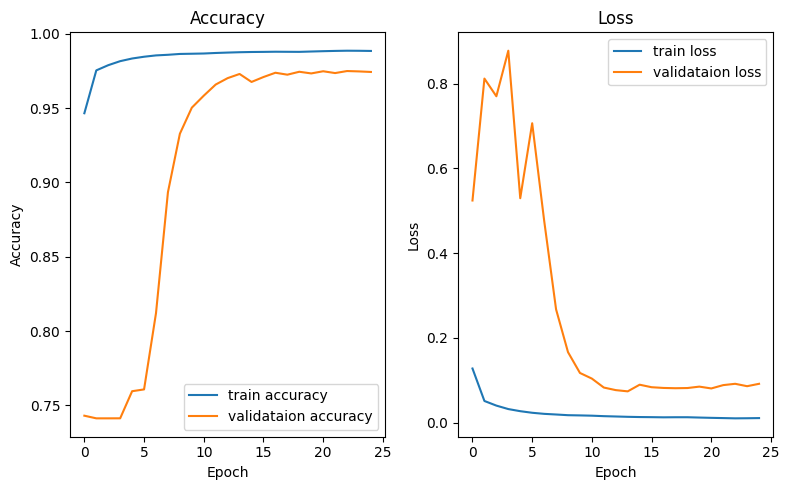

In [27]:
# Display learning curves
# YOUR CODE HERE
display_learning_curves(deeplab_model_history)

### Visualize Predictions (1 points)

In [ ]:
# Inference from model
# YOUR CODE HERE


#### Plot the predictions

In [28]:
def get_test_image_and_annotation_arrays(test):
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''
  images = []
  y_true_segments = []
  for image, annotation in test:
    y_true_segments.append(annotation.numpy())
    images.append(image.numpy())
  print(images[0].shape)

  return images, y_true_segments


In [29]:
def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1) #Stores the highest probability class from the last axis - So the shape is 1,h,w
  pred_mask = pred_mask[..., tf.newaxis] #New Axis is added to the shape - 1,h,w,1
  return pred_mask[0].numpy() #Returns h,w,1

In [30]:
def make_predictions(image, model):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''
  input_shape = model.input_shape
  print(input_shape)
  print(image.shape)
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [31]:
# Please input a number between 0 to 3647 to pick an image from the dataset
Batch_slider = 4
y_true_images, y_true_segments = get_test_image_and_annotation_arrays(test_dataset)
# Get the prediction mask


(4, 512, 512, 3)


(None, 512, 512, 3)
(512, 512, 3)
1/1 [==============================] - 3s 3s/step
(None, 512, 512, 3)
(512, 512, 3)
1/1 [==============================] - 0s 41ms/step
(None, 512, 512, 3)
(512, 512, 3)
1/1 [==============================] - 0s 50ms/step
(None, 512, 512, 3)
(512, 512, 3)
1/1 [==============================] - 0s 37ms/step


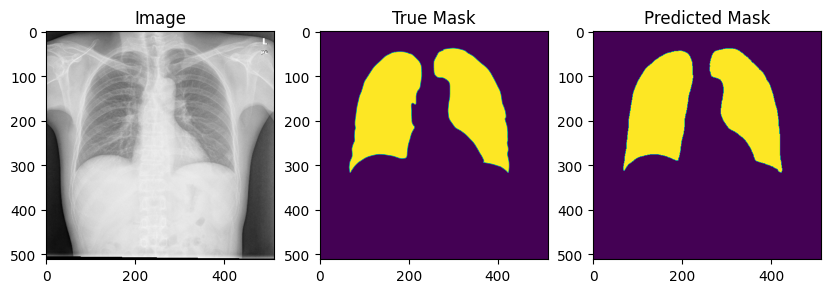

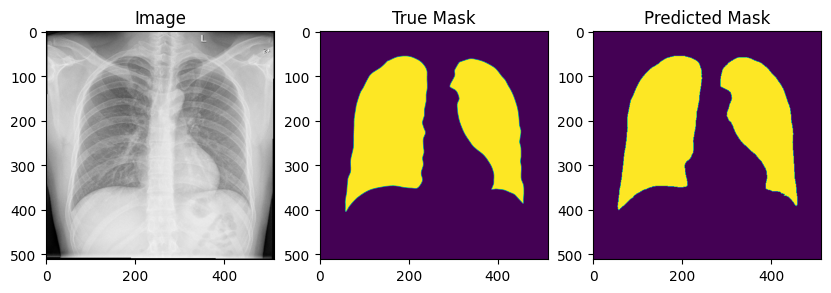

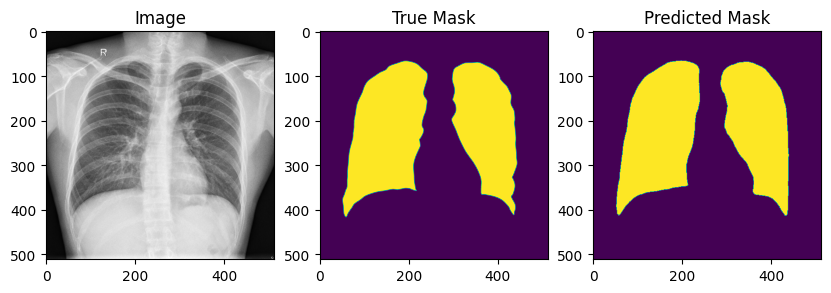

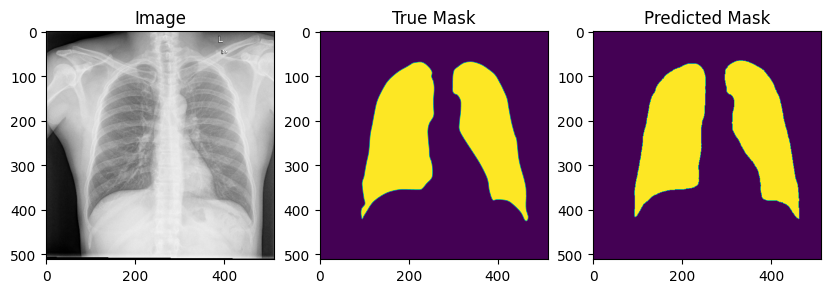

In [32]:
for i in range(BATCH_SIZE):
    y_pred_mask = make_predictions(y_true_images[Batch_slider][i], model = deeplab_model)
    plt.figure(figsize=(10, 10))
    # Original Image
    img_arr = tf.keras.preprocessing.image.array_to_img(y_true_images[Batch_slider][i])
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img_arr)

    # Ground truth Mask
    img_arr = tf.keras.preprocessing.image.array_to_img(y_true_segments[Batch_slider][i])
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(img_arr)
    # Predicted Mask
    img_arr = tf.keras.preprocessing.image.array_to_img(y_pred_mask)
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(img_arr)

